2024-12-19 22:58:11.630098: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 22:58:11.671428: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-12-19 22:58:11.672449: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-19 22:58:12.389067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT



Training model with dropout = 0.1


2024-12-19 22:58:13.611420: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-19 22:58:13.615830: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
162/162 [==============================] - 2s 6ms/step - loss: 1.4252 - accuracy: 0.4503 - val_loss: 1.1136 - val_accuracy: 0.6060
Epoch 2/50
162/162 [==============================] - 1s 4ms/step - loss: 0.9781 - accuracy: 0.6439 - val_loss: 0.8033 - val_accuracy: 0.7337
Epoch 3/50
162/162 [==============================] - 1s 4ms/step - loss: 0.7647 - accuracy: 0.7373 - val_loss: 0.6515 - val_accuracy: 0.7779
Epoch 4/50
162/162 [==============================] - 1s 4ms/step - loss: 0.6423 - accuracy: 0.7762 - val_loss: 0.5610 - val_accuracy: 0.8142
Epoch 5/50
162/162 [==============================] - 1s 4ms/step - loss: 0.5779 - accuracy: 0.8045 - val_loss: 0.5035 - val_accuracy: 0.8235
Epoch 6/50
162/162 [==============================] - 1s 4ms/step - loss: 0.5232 - accuracy: 0.8238 - val_loss: 0.4474 - val_accuracy: 0.8506
Epoch 7/50
162/162 [==============================] - 1s 4ms/step - loss: 0.4969 - accuracy: 0.8312 - val_loss: 0.4562 - val_accuracy: 0.8406
Epoch 

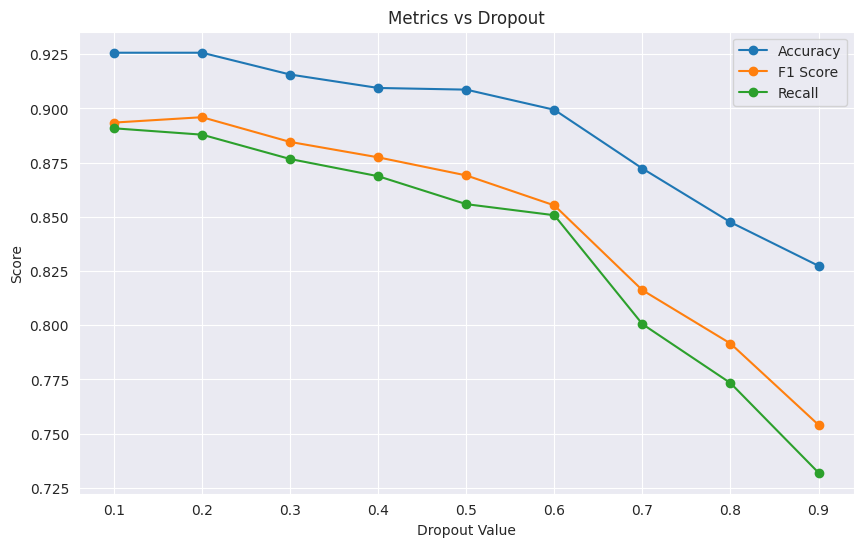

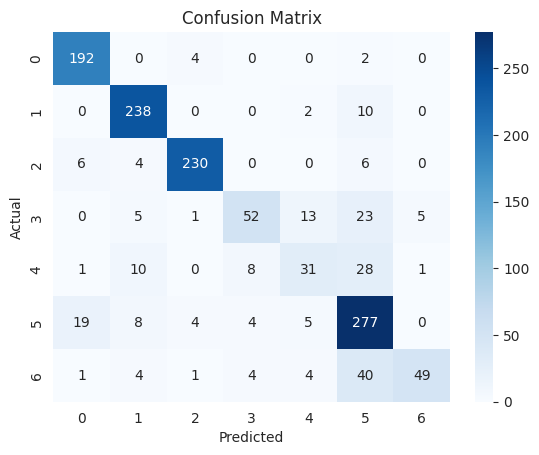

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import joblib
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to parse hand data from a string
def parse_hand_data(hand_str):
    # Parse a string of hand coordinates into a numpy array
    try:
        # Convert the string into a list of floats
        hand_data = np.array([float(v) for v in hand_str.strip('[]').split(',')])
        return hand_data
    except Exception:
        # Return a default value if parsing fails (array of zeros representing no hand landmark data)
        return np.array([0.0] * 21 * 3)  # 21 keypoints, 3 coordinates each

# Function to load data for a specific view and person
def load_data(view_idx, person_idx):
    # Load hand landmark data for all steps of a specific view and person
    all_steps = []
    for step_idx in range(1, 8):  # Steps 1.csv to 7.csv
        file_path = f"../data/landmark/view{view_idx}/{person_idx}/{step_idx}.csv"
        if os.path.exists(file_path):
            # Read the data from the CSV file
            df = pd.read_csv(file_path)
            all_steps.append(df)
        else:
            # Log a warning if the file does not exist
            print(f"Warning: File {file_path} does not exist.")
    return all_steps

# Function to normalize the data
def normalize_data(all_data):
    # Normalize the dataset using StandardScaler (mean=0, std=1)
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(all_data)
    return scaled_data

# Function to create an LSTM model
def create_lstm_model(input_shape, num_classes,dropout):
    # Create and compile an LSTM model for gesture recognition
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=False),
        Dropout(dropout),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')  # Output layer for classification
    ])
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to visualize hand keypoint distribution for all steps
def visualize_hand_distribution_all_steps(X, y, num_steps=7):
    # Visualize the distribution of hand keypoints for each step
    for step in range(num_steps):
        # Left and right hand data are concatenated; split them into separate arrays
        step_data = X[y == step]
        num_features = step_data.shape[1] // 2
        left_hand = step_data[:, :num_features].reshape(-1, 21, 3)
        right_hand = step_data[:, num_features:].reshape(-1, 21, 3)

        # Filter out invalid keypoints with coordinates (0, 0, 0)
        left_hand = left_hand[np.any(left_hand != (0, 0, 0), axis=2)]
        right_hand = right_hand[np.any(right_hand != (0, 0, 0), axis=2)]

        left_hand = left_hand.reshape(-1, 21, 3)
        right_hand = right_hand.reshape(-1, 21, 3)

        # Count total keypoints for each hand
        left_hand_points = left_hand.shape[0] * left_hand.shape[1]
        right_hand_points = right_hand.shape[0] * right_hand.shape[1]

        # Plot the hand keypoints
        plt.figure(figsize=(10, 6))
        for frame in left_hand:
            plt.scatter(frame[:, 0], frame[:, 1], color='blue', alpha=0.7)
        for frame in right_hand:
            plt.scatter(frame[:, 0], frame[:, 1], color='red', alpha=0.7)

        # Add Legend
        plt.scatter([], [], color='blue', label=f'Left Hand ({left_hand_points} points)')
        plt.scatter([], [], color='red', label=f'Right Hand ({right_hand_points} points)')

        plt.title(f"Hand Distribution (Step {step + 1})")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.show()

# Function to visualize the distribution of steps (labels)
def visualize_step_distribution(y, num_steps=7):
    # Plot the distribution of step labels
    step_counts = [np.sum(y == step) for step in range(num_steps)]
    plt.figure(figsize=(10, 6))
    sns.barplot(x=[f"Step {i + 1}" for i in range(num_steps)], y=step_counts, palette='viridis')
    plt.title("Step Distribution")
    plt.xlabel("Step")
    plt.ylabel("Count")
    plt.show()

# Function to plot accuracy over epochs
def visualize_accuracy_and_epochs(history):
    # Plot training and validation accuracy across epochs
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main pipeline for gesture recognition
def generalize_recognition(view_idx=1):
    # Main function to handle data processing, model training, and evaluation
    X, y = [], []

    # Load data for all persons
    for person_idx in range(1, 9):  # 8 individuals
        all_steps = load_data(view_idx, person_idx)
        if not all_steps:
            continue

        all_data = []
        for step in all_steps:
            # Parse left and right hand data
            left_data = step['Left'].apply(parse_hand_data)
            right_data = step['Right'].apply(parse_hand_data)
            step_data = np.concatenate([np.stack(left_data), np.stack(right_data)], axis=1)
            all_data.append(step_data)

        # Concatenate all steps for the current person
        all_data = np.concatenate(all_data, axis=0)
        actions = [step_idx for step_idx, step in enumerate(all_steps, start=1) for _ in range(len(step))]
        X.append(all_data)
        y.append(np.array(actions))

    # Concatenate data from all persons
    X = np.concatenate(X)
    y = np.concatenate(y)

    # Save the dataset for normalization
    joblib.dump(X, 'X.pkl')

    # Shift labels to start from 0
    y -= 1

    # Visualize distribution
    #visualize_step_distribution(y)
    #visualize_hand_distribution_all_steps(X, y, num_steps=7)

    # Normalize the data
    X_normalized = normalize_data(X)

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

    # Reshape the data for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test_lstm = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))



    """
    #### LSTM model
    # Create and train the LSTM model
    model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), len(np.unique(y_train)), 0) # Change forget gate last parameter (0-1)
    history = model.fit(X_train_lstm, y_train, epochs=50, batch_size=32, validation_data=(X_test_lstm, y_test))

    # Visualize accuracy
    #visualize_accuracy_and_epochs(history)

    # Evaluate the model
    y_pred = np.argmax(model.predict(X_test_lstm), axis=1)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2%}")
    print(f"F1 Score: {f1_score(y_test, y_pred, average='macro'):.2%}")
    print(f"Recall: {recall_score(y_test, y_pred, average='macro'):.2%}")

    # Save the trained model
    model.save('generalized_lstm_model.keras')
    ####
    """

    #### LSTM model with optimize dropout
    # Initialize lists to store results
    dropout_values = []
    accuracy_scores = []
    f1_scores = []
    recall_scores = []

    # Track the best accuracy and corresponding dropout value
    best_accuracy = 0
    best_dropout = 0
    best_model = None

    # Loop through different dropout values
    for dropout in np.arange(0.1, 1.0, 0.1):
        print(f"\nTraining model with dropout = {dropout:.1f}")
        dropout_values.append(dropout)  # Store dropout value

        # Create and compile the LSTM model with the current dropout value
        model = create_lstm_model((X_train_lstm.shape[1], X_train_lstm.shape[2]), len(np.unique(y_train)), dropout)

        # Train the model
        history = model.fit(
            X_train_lstm, y_train,
            epochs=50,
            batch_size=32,
            validation_data=(X_test_lstm, y_test),
            verbose=1
        )

        # Evaluate the model on the test set
        y_pred = np.argmax(model.predict(X_test_lstm), axis=1)

        # Calculate metrics
        accuracy = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average='macro')
        recall = recall_score(y_test, y_pred, average='macro')

        # Store metrics
        accuracy_scores.append(accuracy)
        f1_scores.append(f1)
        recall_scores.append(recall)

        print(f"Accuracy: {accuracy:.2%}")
        print(f"F1 Score: {f1:.2%}")
        print(f"Recall: {recall:.2%}")

        # Update the best model if the current one has higher accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_dropout = dropout
            best_model = model

    # Print the best results
    print(f"\nBest Dropout Value: {best_dropout:.1f}")
    print(f"Best Accuracy: {best_accuracy:.2%}")

    # Plotting the results
    plt.figure(figsize=(10, 6))

    # Plot accuracy
    plt.plot(dropout_values, accuracy_scores, marker='o', label='Accuracy')

    # Plot F1 Score
    plt.plot(dropout_values, f1_scores, marker='o', label='F1 Score')

    # Plot Recall
    plt.plot(dropout_values, recall_scores, marker='o', label='Recall')

    # Add labels, legend, and title
    plt.xlabel('Dropout Value')
    plt.ylabel('Score')
    plt.title('Metrics vs Dropout')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Save the best trained model
    best_model.save('generalized_lstm_model.keras')
    ####

    # Plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title("Confusion Matrix")
    plt.show()

# Execute the main pipeline
if __name__ == "__main__":
    #generalize_recognition(view_idx=1)
    #generalize_recognition(view_idx=2)
    generalize_recognition(view_idx=3)

In [ ]:
# Import necessary libraries
import mediapipe as mp
import numpy as np
import cv2
import joblib
from tensorflow.keras.models import load_model
from sklearn.preprocessing import StandardScaler

# Initialize MediaPipe Hands module
mp_drawing = mp.solutions.drawing_utils
mp_hands = mp.solutions.hands

# Load the pre-trained gesture recognition model
model = load_model('generalized_lstm_model.keras')

# Load the existing dataset for normalization
X = joblib.load('X.pkl')

# Function to normalize data
def normalize_data(X):
    # Normalize the dataset (mean=0, std=1)
    return (X - X.mean(axis=0)) / X.std(axis=0)

# Function to extract landmarks from a frame
def extract_landmarks_from_frame(frame):
    # Flip the frame horizontally for a mirrored view
    frame = cv2.flip(frame, 1)

    # Convert frame to RGB (OpenCV uses BGR by default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame to extract hand landmarks
    with mp_hands.Hands(static_image_mode=False, max_num_hands=2, min_detection_confidence=0.5) as hands:
        results = hands.process(frame_rgb)

        # If no landmarks are detected, return None
        if not results.multi_hand_landmarks:
            return None, frame

        landmarks = {}
        for idx, hand_landmarks in enumerate(results.multi_hand_landmarks):
            # Determine if the hand is left or right
            hand_type = "Left" if results.multi_handedness[idx].classification[0].label == "Left" else "Right"
            landmarks[hand_type] = [(lm.x, lm.y, lm.z) for lm in hand_landmarks.landmark]

            # Draw hand landmarks on the frame
            mp_drawing.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        return landmarks, frame

# Function to preprocess landmarks for the model
def preprocess_landmarks(landmarks):
    # Prepare a feature vector from hand landmarks
    feature_vector = []

    # Add landmarks for the left hand or zeros if not detected
    if 'Left' in landmarks:
        left_hand = landmarks['Left']
        feature_vector.extend([coord for lm in left_hand for coord in lm])
    else:
        feature_vector.extend([0] * 63)

    # Add landmarks for the right hand or zeros if not detected
    if 'Right' in landmarks:
        right_hand = landmarks['Right']
        feature_vector.extend([coord for lm in right_hand for coord in lm])
    else:
        feature_vector.extend([0] * 63)

    return np.array(feature_vector).reshape(1, -1)

# Function to detect gestures from an image
def detect_image(image_path):
    global X

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Could not load image.")
        return

    # Extract landmarks from the image
    landmarks, frame_with_landmarks = extract_landmarks_from_frame(image)

    if landmarks:
        # Preprocess the landmarks into a feature vector
        feature_vector = preprocess_landmarks(landmarks)

        # Append the feature vector to the dataset
        X = np.concatenate((X, feature_vector), axis=0)

        # Normalize the data
        X_normalized = normalize_data(X)
        X_last_normalized = X_normalized[-1]
        X_lstm_input = X_last_normalized.reshape((1, 1, X_last_normalized.shape[0]))

        # Make gesture prediction
        predictions = model.predict(X_lstm_input)
        predicted_class = np.argmax(predictions, axis=1)
        predicted_gesture = f"Gesture: Step {predicted_class[0] + 1}"

        # Display the predicted gesture on the image
        cv2.putText(frame_with_landmarks, predicted_gesture, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

    # Show the processed image with landmarks and prediction
    cv2.imshow("Image Feed", frame_with_landmarks)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

# Function to detect gestures using a webcam
def detect_camera():
    global X

    # Start video capture from the webcam
    cap = cv2.VideoCapture(0)
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Extract landmarks from the current frame
        landmarks, frame_with_landmarks = extract_landmarks_from_frame(frame)

        if landmarks:
            # Preprocess the landmarks into a feature vector
            feature_vector = preprocess_landmarks(landmarks)

            # Append the feature vector to the dataset
            X = np.concatenate((X, feature_vector), axis=0)

            # Normalize the data
            X_normalized = normalize_data(X)
            X_last_normalized = X_normalized[-1]
            X_lstm_input = X_last_normalized.reshape((1, 1, X_last_normalized.shape[0]))

            # Make gesture prediction
            predictions = model.predict(X_lstm_input)
            predicted_class = np.argmax(predictions, axis=1)
            predicted_gesture = f"Gesture: Step {predicted_class[0] + 1}"

            # Display the predicted gesture on the frame
            cv2.putText(frame_with_landmarks, predicted_gesture, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2, cv2.LINE_AA)

        # Show the frame with landmarks and prediction
        cv2.imshow("Webcam Feed", frame_with_landmarks)

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    cap.release()
    cv2.destroyAllWindows()

# Main execution
if __name__ == "__main__":
    # # Start gesture detection using image
    #for i in range(81, 90):
    #    detect_image(f'../data/image/view3/p1/1/{i}.jpg')

    #detect_image('../data/image/view3/p1/1/68.jpg')
    #detect_image('../data/image/view3/p1/2/502.jpg')
    #detect_image('../data/image/view3/p1/3/260.jpg')
    #detect_image('../data/image/view3/p1/4/901.jpg')
    #detect_image('../data/image/view3/p1/5/2178.jpg')
    #detect_image('../data/image/view3/p1/6/1696.jpg')
    #detect_image('../data/image/view3/p1/7/2244.jpg')

    # Start gesture detection using the webcam
    #detect_camera()
